# Final RFC Model

In [1]:
import pandas as pd
import numpy as np
import pickle



### Read in Data


In [3]:
data_path = 'final_data.xlsx'
#Change the data path to your file name
df = pd.read_excel(data_path)
print(df.shape)

(14580, 22)


### Data Preprocessing

In [4]:
anomalies = 'Tomato Juice'
#If anomalies found in data, remove them. Set aomalies to the anomalous food

df = df[df['Food']!=anomalies]

In [5]:
columns_to_drop = ['Sodium', 'Protein', 'Cholesterol', 'Fat', 'Potassium','L', 'Conductivity (100H)', 'Conductivity (100kH)']
# After feature analysis, drop features that are highly corellated or have
# a low mutual information score. Edit the variable columns_to_drop

df=df.drop(columns= columns_to_drop)

### Feature Engineering

In [6]:
df['Last5Z'] = df.groupby('Food')['Z(Ohm)'].transform(lambda x: x.rolling(window=5, center=True).mean())
df['Last5increase'] = df.groupby('Food')['Z(Ohm)'].transform(lambda x: x.shift(-2)-x.shift(2))
df['Last5freq'] = df.groupby('Food')['Freq(Hz)'].transform(lambda x: x.shift(-2)-x.shift(2))
df['Last5slope'] = df['Last5increase']/df['Last5freq']
df['Last5increasePA'] = df.groupby('Food')['PA'].transform(lambda x: x.shift(-2)-x.shift(2))
df['Last5PA'] = df.groupby('Food')['PA'].transform(lambda x: x.rolling(window=5, center=True).mean())
df['Last5slopePA'] = df['Last5increasePA']/df['Last5freq']

In [7]:
df=df.dropna()
# Drop all null values

In [8]:
dfcopy = df.copy()
#Incase we need a copy later

### TrainTestSplit

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop(columns = ['R+'])
y = df['R+']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Splitting the data. Can experiemnt with test_size or random_state

# Drop 'Food' column because it does not contibute to the output
X_train = X_train.drop(columns = ['Food'])
X_test_foods = X_test.copy()
# Create a copy of X_test because we will need it to analyse accuracy by food later
X_test = X_test.drop(columns = ['Food'])
y_train = y_train.drop(columns = ['Food'])
y_test = y_test.drop(columns = ['Food'])

### Pipeline and Model Training

In [12]:
ss=[]
ss = ['Z(Ohm)', 'Last5Z', 'Last5increase', 'PA']

# Add the variables you want to standard scale into the variable ss

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ss)
    ], remainder='passthrough'
)

In [66]:
# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(criterion = 'gini', random_state=42,max_depth = None, min_samples_split=2,n_estimators=150 ))
])
#these hyper params are based on the testing in the next code block, I would run the GridSearch CV again if using different training data


In [57]:
#this is the hyper parameter tuning.

from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200, 300],
    'classifier__max_depth': [None, 5, 10, 15, 20, 30],
    'classifier__min_samples_split': [1,2, 5, 10, 15, 20,25]
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

#the best hyper params were: {'classifier__max_depth': None,
# 'classifier__min_samples_split': 2,
# 'classifier__n_estimators': 150}
#I have applied these to the model above, however if you are using a different training dataset, I would run the hyper parameterization again



Fitting 5 folds for each of 210 candidates, totalling 1050 fits


KeyboardInterrupt: 

In [68]:

pipeline.fit(X_train, y_train)

C:\Users\markt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Z(Ohm)', 'Last5Z',
                                                   'Last5increase', 'PA'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

In [69]:
pickle.dump(X_test, open('X_test.pkl', 'wb'))
pickle.dump(y_test, open('y_test.pkl', 'wb'))
y_pred = pipeline.predict(X_test)

In [70]:
print("Test set predictions:", y_pred)
print("Model accuracy on test set:", pipeline.score(X_test, y_test))

Test set predictions: [1 1 0 ... 1 1 1]
Model accuracy on test set: 0.9157549234135668


In [34]:
import pickle
save_path = 'finalmodel2.pkl'
pickle.dump(pipeline, open(save_path, 'wb'))
# Save the model to use it later. Edit save_path as necessary

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
confusion_matrix(y_test, y_pred)

array([[1340,  117],
       [ 114, 1171]], dtype=int64)

### Feature Importance - Unimportant for now

In [19]:
# We might need feature importance to reduce dimensionality further. If a variable
# has a very low importance, we can experiment dropping it and re-training the model

In [37]:
model = pipeline.named_steps['classifier']


In [21]:
fi = model.feature_importances_

In [22]:
fidf = pd.DataFrame()

In [23]:
fidf['columns']=X_train.columns
fidf['imp'] = fi
fidf

,columns,imp
0,Freq(Hz),0.128928
1,Z(Ohm),0.121543
2,PA,0.075868
3,Time(m),0.081928
4,Total carbohydrate,0.043440
5,pH,0.020682
6,ORP,0.012939
7,Conductivity (400H),0.015724
8,Conductivity (10kH),0.015798
9,DO (ppm),0.020749


### Splitting into frequency and food

In [38]:
results = X_test_foods.copy()
results['true'] = y_test.values
results['pred'] = y_pred
results['correct'] = results['true'] == results['pred']


In [39]:
bins = [100007, 56243.5, 31634.1, 17778.2, 9998.2, 5622.14, 
        3162.67, 1778.51, 999.95, 562.189, 316.113, 177.836, 100.009, 9.9987]
bins = bins[::-1]
bins2 = [100007, 56243.5, 31634.1,28173.1, 25123.7, 22389.3, 19954.4, 17778.2, 9998.2, 5622.14, 
        3162.67, 1778.51, 999.95, 562.189, 316.113, 177.836, 100.009, 9.9987]
bins2 = bins2[::-1]

# Analyse the accuracy by frequency. bins has an even distributuon of frequencies,
# and bins2 has it further split to find the single best frequency

In [40]:

labels = ['9-100', '100-177', '177-316', '316-562', '562-999', '999-1778',
         '1778-3162', '3162-5622', '5622-9998', '9998-17778', '17778-31634',
         '31634-56243', '>56243']
labels2 = ['9-100', '100-177', '177-316', '316-562', '562-999', '999-1778',
         '1778-3162', '3162-5622', '5622-9998', '9998-17778', '17778-19954','19954+','22389+', '25123+', '28173+', '31634-56243', '>56243']


In [41]:
results['frequency_bin'] = pd.cut(results['Freq(Hz)'], bins=bins2, labels=labels2, right=False)

In [42]:
pickle.dump(results, open('results.pkl', 'wb'))
# Save outr resuls df for later to analyse it in the 'final_model_food_analysis' file

In [43]:
import matplotlib.pyplot as plt

C:\Users\markt\AppData\Local\Temp\ipykernel_32696\2915935425.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_bin = results.groupby('frequency_bin')['correct'].mean()


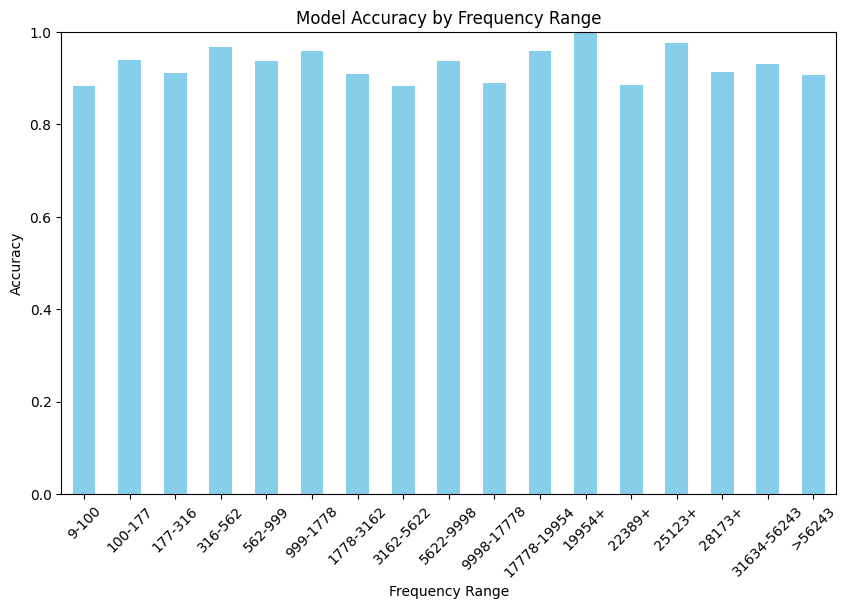

In [44]:
accuracy_by_bin = results.groupby('frequency_bin')['correct'].mean()

# Plot accuracy versus frequency range
plt.figure(figsize=(10, 6))
accuracy_by_bin.plot(kind='bar', color='skyblue')
plt.xlabel('Frequency Range')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Frequency Range')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [45]:
accuracy_by_bin

frequency_bin
9-100          0.883552
100-177        0.939189
177-316        0.911917
316-562        0.968553
562-999        0.938202
999-1778       0.959302
1778-3162      0.909639
3162-5622      0.884146
5622-9998      0.938202
9998-17778     0.890323
17778-19954    0.958333
19954+         1.000000
22389+         0.885714
25123+         0.975610
28173+         0.914286
31634-56243    0.931818
>56243         0.906433
Name: correct, dtype: float64

In [46]:
accuracy_per_food = results.groupby('Food')['correct'].mean().sort_values(ascending = False)

In [33]:
accuracy_per_food


Food
Apple Juice        1.000000
Cream              1.000000
Cranberry Juice    0.994253
Grape Juice        0.993333
Chicken            0.987261
Milk0              0.972603
Half and Half      0.970238
Orange Juice       0.958621
Tomato Paste       0.957447
Soy Bean           0.923077
Beef               0.890295
Milk1              0.884615
Yogurt             0.865031
Veg Soup           0.831395
Milk2              0.780899
Milk34             0.606250
Name: correct, dtype: float64

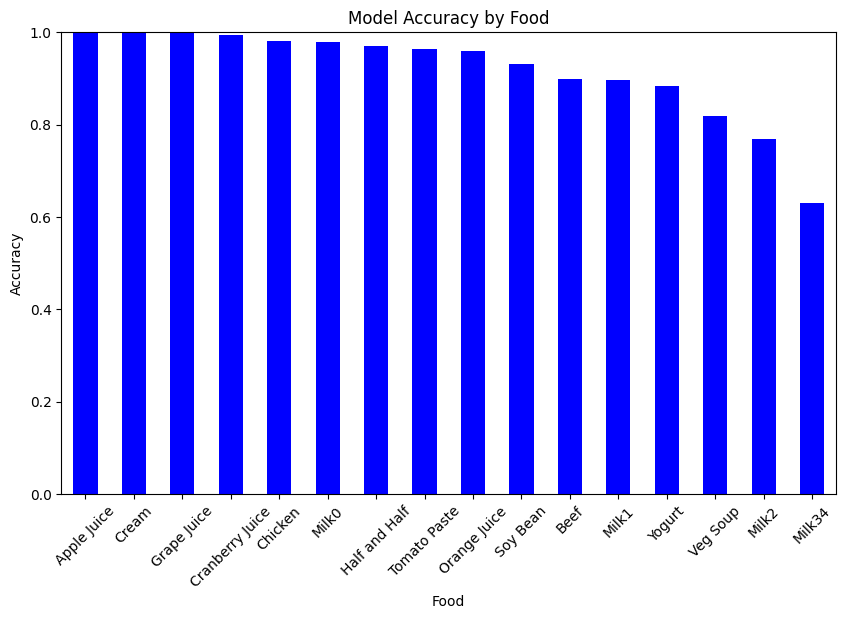

In [47]:
plt.figure(figsize=(10, 6))
accuracy_per_food.plot(kind='bar', color='blue')
plt.xlabel('Food')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Food')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()